In [1]:
import pandas as pd
import numpy as np
import os

base_path = "/data/user_data/sbharad2/SpeechCLIP/data"

embedding_read_path_pattern = (
    "{base_path}/Flickr8k.{csv_name}.token.txt.audio_embeddings/"
)

# FLICKR
csv_path_pattern = "{base_path}/flickr/{csv_name}.csv"

dev_df = pd.read_csv(
    csv_path_pattern.format(base_path=base_path, csv_name="flickr_dev_sampled")
)

# change target type as list
dev_df["target"] = dev_df["target"].apply(eval)

print("Dev size:", dev_df.shape)

Dev size: (1000, 6)


In [2]:
def _load_embeddings(df, embedding_read_path):
    embeddings = {}
    for i, r in df.iterrows():
        try:
            example_id = r["example_id"]
            embedding = np.load(os.path.join(embedding_read_path, example_id) + ".npy")
            embeddings[example_id] = embedding
        except FileNotFoundError:
            print(f"File not found for {example_id}.npy")

    return embeddings


embeddings = _load_embeddings(
    dev_df,
    embedding_read_path_pattern.format(
        base_path=base_path, csv_name="flickr_dev_sampled"
    ),
)

In [3]:
def _get_image_id(example_id):
    return example_id.split("#")[0]


def _get_caption_id(example_id):
    return example_id.split("#")[1]


def compute_intra_image_similarities(embeddings):
    images_seen = set()
    similarities = []
    for example_id in embeddings.keys():
        image_id = _get_image_id(example_id)
        if image_id in images_seen:
            continue
        within_image_similarities = []  # Should have 10 numbers (5C2)
        for cid1 in range(5):
            for cid2 in range(cid1 + 1, 5):
                ex1 = image_id + "#" + str(cid1)
                ex2 = image_id + "#" + str(cid2)
                sim = np.dot(embeddings[ex1], embeddings[ex2]) / (
                    np.linalg.norm(embeddings[ex1]) * np.linalg.norm(embeddings[ex2])
                )
                within_image_similarities.append(sim)
        assert len(within_image_similarities) == 10
        # add mean similarity
        similarities.append(np.mean(within_image_similarities))
        images_seen.add(image_id)
    return similarities


def compute_inter_image_similarities(embeddings):
    images = list(set([_get_image_id(example_id) for example_id in embeddings.keys()]))
    inter_image_similarities = []
    for i in range(len(images)):
        outside_image_similarities = []
        for j in range(len(images)):
            if i == j:
                continue
            sim = np.dot(embeddings[images[i] + "#0"], embeddings[images[j] + "#0"]) / (
                np.linalg.norm(embeddings[images[i] + "#0"])
                * np.linalg.norm(embeddings[images[j] + "#0"])
            )
            outside_image_similarities.append(sim)
        assert len(outside_image_similarities) == len(images) - 1
        inter_image_similarities.append(np.mean(outside_image_similarities))
    return inter_image_similarities

In [4]:
intra_image_similarities = compute_intra_image_similarities(embeddings)
inter_image_similarities = compute_inter_image_similarities(embeddings)
print(
    "Intra image similarities:",
    np.mean(intra_image_similarities),
    len(intra_image_similarities),
)
print(
    "Inter image similarities:",
    np.mean(inter_image_similarities),
    len(inter_image_similarities),
)

Intra image similarities: 0.5353096 200
Inter image similarities: 0.026794724 200


/tmp/ipykernel_3472801/791356709.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(inter_image_similarities, color='blue', label='Inter-image similarity', shade=True, bw_adjust=0.5)
/tmp/ipykernel_3472801/791356709.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(intra_image_similarities, color='red', label='Intra-image similarity', shade=True, bw_adjust=1.5)


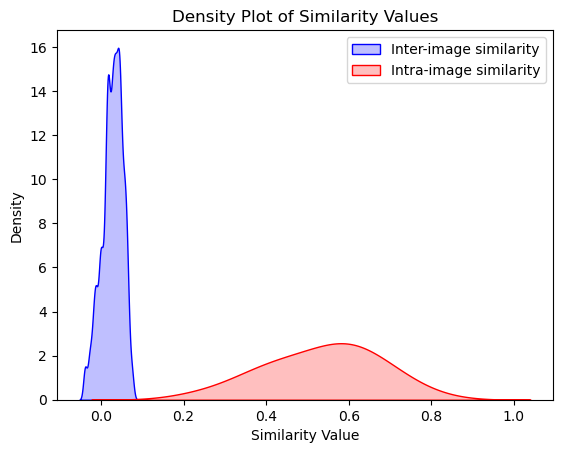

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Create the density plot
sns.kdeplot(
    inter_image_similarities,
    color="blue",
    label="Inter-image similarity",
    shade=True,
    bw_adjust=0.5,
)
sns.kdeplot(
    intra_image_similarities,
    color="red",
    label="Intra-image similarity",
    shade=True,
    bw_adjust=1.5,
)

# Add labels and title
plt.title("Density Plot of Similarity Values")
plt.xlabel("Similarity Value")
plt.ylabel("Density")

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [6]:
# Compute similarity between clean and noisy embeddings
def compute_similarity_between_clean_and_noisy(embeddings, noisy_embeddings):
    similarities = []
    for example_id in embeddings.keys():
        sim = np.dot(embeddings[example_id], noisy_embeddings[example_id]) / (
            np.linalg.norm(embeddings[example_id])
            * np.linalg.norm(noisy_embeddings[example_id])
        )
        similarities.append(sim)
    return similarities


for snr in range(5, 41, 5):
    noisy_embeddings = _load_embeddings(
        dev_df,
        base_path
        + f"/noisy.Flickr8k.flickr_dev_sampled.token.txt.audio_embeddings.snr{snr}.0/",
    )
    print(f"SNR: {snr}")
    print(
        "Similarity between clean and noisy embeddings:",
        np.mean(
            compute_similarity_between_clean_and_noisy(embeddings, noisy_embeddings)
        ),
        len(compute_similarity_between_clean_and_noisy(embeddings, noisy_embeddings)),
    )

SNR: 5
Similarity between clean and noisy embeddings: 0.6877745 1000
SNR: 10
Similarity between clean and noisy embeddings: 0.8224286 1000
SNR: 15
Similarity between clean and noisy embeddings: 0.8951697 1000
SNR: 20
Similarity between clean and noisy embeddings: 0.93501985 1000
SNR: 25
Similarity between clean and noisy embeddings: 0.95570433 1000
SNR: 30
Similarity between clean and noisy embeddings: 0.9684445 1000
SNR: 35
Similarity between clean and noisy embeddings: 0.9773079 1000
SNR: 40
Similarity between clean and noisy embeddings: 0.9843936 1000


# FAST-VGS

In [18]:
import numpy as np

f_dev_embedding_path = "/data/user_data/sbharad2/SpeechCLIP/data/Fastvgs_embeddings/embeddings_flickr_dev_matrix_clean.npy"
f_dev_txt_path = "/data/user_data/sbharad2/SpeechCLIP/data/Fastvgs_embeddings/embeddings_flickr_dev_clean.txt"

f_dev_emb = np.load(f_dev_embedding_path)


def _transform_wav_name_to_example_id(wav_name):
    wav_name = wav_name.replace(".wav", "")
    caption_id = wav_name[-1]
    img_id = wav_name[:-2]
    return f"{img_id}#{caption_id}"


with open(f_dev_txt_path, "r") as f:
    f_dev_names = [line.strip() for line in f.readlines()]
    f_dev_names = [_transform_wav_name_to_example_id(name) for name in f_dev_names]

f_dev_emb_dict = {name: emb for name, emb in zip(f_dev_names, f_dev_emb)}
# normalize
f_dev_emb_dict = {k: v / np.linalg.norm(v) for k, v in f_dev_emb_dict.items()}

In [16]:
intra_image_similarities = compute_intra_image_similarities(f_dev_emb_dict)
inter_image_similarities = compute_inter_image_similarities(f_dev_emb_dict)
print(
    "Intra image similarities:",
    np.mean(intra_image_similarities),
    len(intra_image_similarities),
)
print(
    "Inter image similarities:",
    np.mean(inter_image_similarities),
    len(inter_image_similarities),
)

Intra image similarities: 0.72111505 200
Inter image similarities: 0.20753881 200


/tmp/ipykernel_3472801/2633796563.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_3472801/2633796563.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


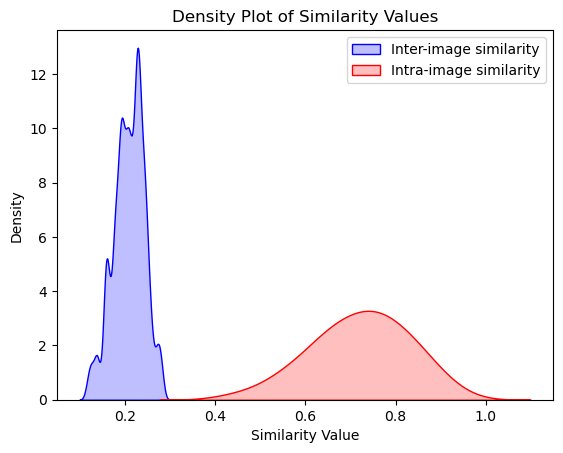

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Create the density plot
sns.kdeplot(
    inter_image_similarities,
    color="blue",
    label="Inter-image similarity",
    shade=True,
    bw_adjust=0.5,
)
sns.kdeplot(
    intra_image_similarities,
    color="red",
    label="Intra-image similarity",
    shade=True,
    bw_adjust=1.5,
)

# Add labels and title
plt.title("Density Plot of Similarity Values")
plt.xlabel("Similarity Value")
plt.ylabel("Density")

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [23]:
f_dev_embedding_noisy_pattern = "/data/user_data/sbharad2/SpeechCLIP/data/Fastvgs_embeddings/embeddings_flickr_dev_matrix_snr{snr}.npy"


# Compute similarity between clean and noisy embeddings
def compute_similarity_between_clean_and_noisy(embeddings, noisy_embeddings):
    similarities = []
    for example_id in embeddings.keys():
        sim = np.dot(embeddings[example_id], noisy_embeddings[example_id]) / (
            np.linalg.norm(embeddings[example_id])
            * np.linalg.norm(noisy_embeddings[example_id])
        )
        similarities.append(sim)
    return similarities


for snr in range(5, 41, 5):
    f_dev_txt_path = "/data/user_data/sbharad2/SpeechCLIP/data/Fastvgs_embeddings/embeddings_flickr_dev_clean.txt"
    f_dev_emb_noisy = np.load(f_dev_embedding_noisy_pattern.format(snr=snr))

    def _transform_wav_name_to_example_id(wav_name):
        wav_name = wav_name.replace(".wav", "")
        caption_id = wav_name[-1]
        img_id = wav_name[:-2]
        return f"{img_id}#{caption_id}"

    with open(f_dev_txt_path, "r") as f:
        f_dev_names = [line.strip() for line in f.readlines()]
        f_dev_names = [_transform_wav_name_to_example_id(name) for name in f_dev_names]

    f_dev_emb_noisy_dict = {
        name: emb for name, emb in zip(f_dev_names, f_dev_emb_noisy)
    }
    # normalize
    f_dev_emb_noisy_dict = {
        k: v / np.linalg.norm(v) for k, v in f_dev_emb_noisy_dict.items()
    }
    print(f"SNR: {snr}")
    print(
        "Similarity between clean and noisy embeddings:",
        np.mean(
            compute_similarity_between_clean_and_noisy(
                f_dev_emb_dict, f_dev_emb_noisy_dict
            )
        ),
        len(
            compute_similarity_between_clean_and_noisy(
                f_dev_emb_dict, f_dev_emb_noisy_dict
            )
        ),
    )

SNR: 5
Similarity between clean and noisy embeddings: 0.7058549 1000
SNR: 10
Similarity between clean and noisy embeddings: 0.860879 1000
SNR: 15
Similarity between clean and noisy embeddings: 0.9291357 1000
SNR: 20
Similarity between clean and noisy embeddings: 0.9631754 1000
SNR: 25
Similarity between clean and noisy embeddings: 0.9795518 1000
SNR: 30
Similarity between clean and noisy embeddings: 0.9876079 1000
SNR: 35
Similarity between clean and noisy embeddings: 0.99257004 1000
SNR: 40
Similarity between clean and noisy embeddings: 0.9954027 1000
